In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import sys
sys.path.insert(0, "..")


import hydra
from hydra import compose, initialize

from torch.utils.data import DataLoader
import pytorch_lightning as pl

from helpers.dataset import get_datasets, get_dataloaders
from helpers.pl_module import SeizurePredictor

In [15]:
cfgs_path = "../configs"
with initialize(config_path=cfgs_path, version_base="1.1"):
    cfg = compose(config_name="train.yaml", overrides=["model=patch_tst", "username=cizinsky", "data.batch_size=40"])

In [4]:
pl.seed_everything(cfg.seed);

Seed set to 42


### Batch and LR finder

---

**Motivation**. We are testing many different models of varying sizes in this project. Further, we are also testing different filtering techniques. These impact the total batch size we can afford to train with assuming a fixed GPU memory (for V100, this is 32GB). And consequently, the corresponding learning rate. Instead of trying to guess these, we can make use of automatic finder techniques provided by pytorch-lightning.

### Batch size finder

🚨 I have tried this method, and it is extremely slow. It starts from batch size 1 and then increases by a factor of 2 until the model runs out of memory. So I would probably just find the batch size manually.

In [5]:
class LitDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def train_dataloader(self):
        train_dataset, _ = get_datasets(cfg)
        return DataLoader(train_dataset, batch_size=self.batch_size, num_workers=cfg.data.num_workers)
    
    def val_dataloader(self):
        _, val_dataset = get_datasets(cfg)
        return DataLoader(val_dataset, batch_size=self.batch_size, num_workers=cfg.data.num_workers)

datamodule = LitDataModule(batch_size=cfg.data.batch_size)

In [6]:
model = hydra.utils.instantiate(cfg.model.module)
pl_module = SeizurePredictor(cfg, model)

In [ ]:
trainer = pl.Trainer(
    default_root_dir=cfg.output_dir,
    max_epochs=cfg.trainer.max_epochs,
    accelerator=cfg.trainer.accelerator,
    devices=cfg.trainer.devices,
    deterministic=True,
    precision=cfg.trainer.precision,
    enable_progress_bar=False,
    check_val_every_n_epoch=cfg.trainer.check_val_every_n_epoch,
)

In [ ]:
tuner = pl.tuner.tuning.Tuner(trainer)
tuner.scale_batch_size(pl_module, datamodule=datamodule, mode="power")

### LR finder

In [16]:

trn_dataloader, val_dataloader = get_dataloaders(cfg)
model = hydra.utils.instantiate(cfg.model.module)
pl_module = SeizurePredictor(cfg, model)

trainer = pl.Trainer(
    default_root_dir=cfg.output_dir,
    max_epochs=cfg.trainer.max_epochs,
    accelerator=cfg.trainer.accelerator,
    devices=cfg.trainer.devices,
    deterministic=True,
    precision=cfg.trainer.precision,
    enable_progress_bar=False,
    check_val_every_n_epoch=None
)

tuner = pl.tuner.tuning.Tuner(trainer)

/home/cizinsky/venvs/netml/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/cizinsky/venvs/netml/lib/python3.10/site-pack ...
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
# Run learning rate finder
lr_finder = tuner.lr_find(pl_module, trn_dataloader, min_lr=1e-6, max_lr=1e-2, num_training=100, update_attr=False)
# Results can be found in
# lr_finder.results

/home/cizinsky/venvs/netml/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /scratch/izar/cizinsky/netml/outputs/.lr_find_977d891b-72c0-4470-a1e9-119c39cce9be.ckpt
Restored all states from the checkpoint at /scratch/izar/cizinsky/netml/outputs/.lr_find_977d891b-72c0-4470-a1e9-119c39cce9be.ckpt


Suggested LR: 1.58e-04


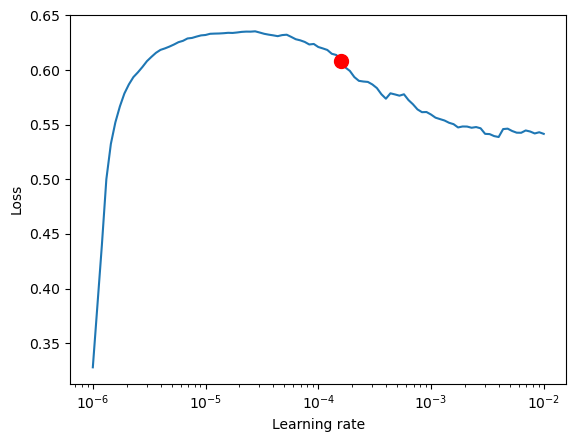

In [18]:
# Pick point based on plot, or get suggestion
new_suggested_lr = lr_finder.suggestion()

# Print the suggested LR using scientific notation
print(f"Suggested LR: {new_suggested_lr:.2e}")

fig = lr_finder.plot(suggest=True)
fig.show()